<a href="https://colab.research.google.com/github/Pilo1961/Deep_Learning/blob/master/autoencoders/DL_09_AE_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
# GOALS:
# - Train ourselves on unsupervised deep learning.
# - Train ourselves on the use of autoencoders (AE).
# - Use an AE to estimate latent representations of some numeric data.
# - Use those latent representations to detect anomalies (abnormal data).

In [0]:
# Data set: https://www.kaggle.com/mlg-ulb/creditcardfraud
# https://www.kaggle.com/mlg-ulb/creditcardfraud/download
#
# The datasets contains transactions made by credit cards in September 2013 by european cardholders.
# This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.
# The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
#
# It contains only numerical input variables which are the result of a PCA transformation (privacy reasons).
# Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are
# 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
# The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud
# and 0 otherwise.

# Part 1: Load data

In [0]:
# Load data
df = pd.read_csv("creditcard.csv")
print(df.shape)



(284807, 31)


False

In [2]:
#load data from google drive
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/My Drive/data/creditcard.csv"
df=pd.read_csv(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Remueve entries with nan values
df.dropna(inplace=True)
df.isnull().values.any()

False

In [4]:
# Show a summary
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
# Note classes are not balanced at all
classes_count = pd.value_counts(df['Class'], sort = True)
classes_count

0    284315
1       492
Name: Class, dtype: int64

In [6]:
# summary of class 0 (normal transactions)
df[df.Class == 0].Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [7]:
# summary of class 1 (abnormal transactions)
df[df.Class == 1].Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

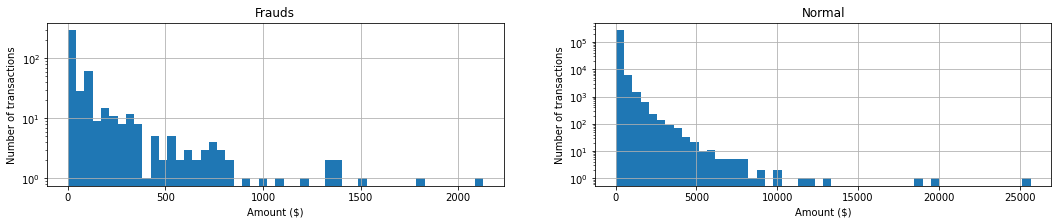

In [8]:
# Plot amount of normal and abnormal data
plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Frauds')
plt.hist(df[df.Class == 1].Amount, bins=50)
plt.xlabel('Amount ($)')
plt.ylabel('Number of transactions')
plt.yscale('log')
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Normal')
plt.hist(df[df.Class == 0].Amount, bins=50)
plt.xlabel('Amount ($)')
plt.ylabel('Number of transactions')
plt.yscale('log')
plt.grid()

plt.show()

In [9]:
# Remove time
df = df.drop(['Time'], axis=1)
print(df.shape)

(284807, 30)


In [10]:
# Extract into matrices values for normal transactions
normal = df[df.Class == 0]
normal = normal.drop(['Class'], axis=1)
normal = normal.values
print(normal.shape)

# Extract into matrices values for normal transactions
frauds = df[df.Class == 1]
frauds = frauds.drop(['Class'], axis=1)
frauds = frauds.values
print(frauds.shape)

(284315, 29)
(492, 29)


In [11]:
# Normalize data
scaler = StandardScaler()
normal = scaler.fit_transform(normal)
frauds = scaler.transform(frauds)

# See max and min values, so we can decide on output activations
print(normal.min(axis=0))
print(normal.max(axis=0))

[-29.23383553 -44.43954405 -33.1210661   -4.05573252 -83.82683084
 -19.67269346 -26.9547933  -63.04736881  -5.77875015 -14.1265026
  -4.77604318 -16.02201219  -5.8207973  -20.51734046  -4.79911288
 -11.98281313 -22.82988537  -6.51040776  -8.88513979 -70.83041283
 -48.59368815 -15.107939   -72.09157992  -4.68293974 -19.77314077
  -5.40075462 -56.43521184 -46.81853823  -0.35301631]
[  1.26783021  11.55688816   6.42059588  12.06519875  25.6429718
  55.11588798 102.28946604  16.11172234  14.31150875  22.73057889
   9.97773414   8.28549613   7.16203997  11.72201079   9.70165636
  20.48834873  12.33161046   6.10628824   6.89039166  51.23659381
  31.55405666  14.5137363   36.24600145   7.56776948  14.44221515
   7.29394756  79.06170547 102.70355447 102.36862343]


In [12]:
# Split normal data into training and test data
x_train, x_test = train_test_split(normal, test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(227452, 29)
(56863, 29)


In [13]:

print(frauds[:,28].mean())
print(frauds[:,28].std())

print(normal[:,28].mean())
print(normal[:,28].std())

0.13562442118567758
1.0252600108212675
7.197520633765677e-18
1.0


# Part 2: Train a model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

In [15]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(32, activation='relu')(in_layer)
encoder = Dense(24,  activation='relu')(encoder)

latent  = Dense(16,  activation='relu')(encoder)

decoder = Dense(24, activation='relu')(latent)
decoder = Dense(32, activation='relu')(decoder)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_5 (Dense)              (None, 29)                957   

In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [18]:
# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.4586 - accuracy: 0.3869 - val_loss: 0.2904 - val_accuracy: 0.4950
Epoch 2/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.2644 - accuracy: 0.5326 - val_loss: 0.2260 - val_accuracy: 0.5610
Epoch 3/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.2032 - accuracy: 0.6083 - val_loss: 0.1669 - val_accuracy: 0.6347
Epoch 4/30
2844/2844 [==============================] - 9s 3ms/step - loss: 0.1645 - accuracy: 0.6512 - val_loss: 0.1420 - val_accuracy: 0.6729
Epoch 5/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1430 - accuracy: 0.6715 - val_loss: 0.1300 - val_accuracy: 0.6834
Epoch 6/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1345 - accuracy: 0.6828 - val_loss: 0.1228 - val_accuracy: 0.6885
Epoch 7/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1257 - accuracy: 0.6920 - val_loss: 0.1189 - val_accuracy:

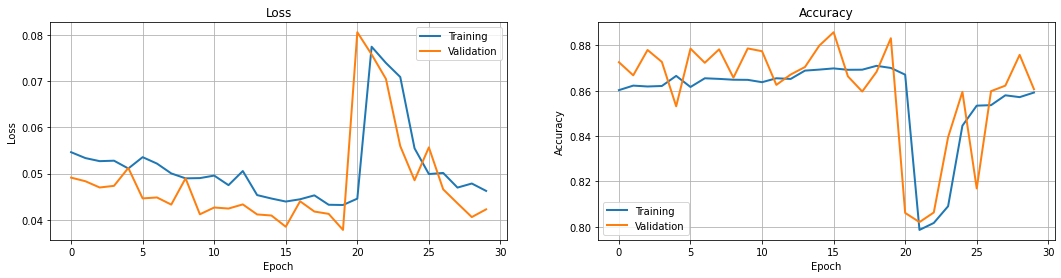

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [71]:
# Predict reconstruction error on training data
x_train_hat = AE.predict(x_train)
mse_train = np.mean(np.power(x_train - x_train_hat, 2), axis=1)

print(f"Min : {mse_train.min():0.6f}")
print(f"Mean: {mse_train.mean():0.4f}")
print(f"Stdd: {mse_train.std():0.2f}")
print(f"Max : {mse_train.max():0.2f}")

Min : 0.002876
Mean: 0.1668
Stdd: 1.09
Max : 497.89


In [72]:
# Predict reconstruction error on test data
x_test_hat = AE.predict(x_test)
mse_test = np.mean(np.power(x_test - x_test_hat, 2), axis=1)

print(f"Min : {mse_test.min():0.6f}")
print(f"Mean: {mse_test.mean():0.4f}")
print(f"Stdd: {mse_test.std():0.2f}")
print(f"Max : {mse_test.max():0.2f}")

Min : 0.003680
Mean: 0.1624
Stdd: 0.21
Max : 26.86


In [73]:
# Predict reconstruction error on abnormal data
frauds_hat = AE.predict(frauds)
mse_frauds = np.mean(np.power(frauds - frauds_hat, 2), axis=1)

print(f"Min : {mse_frauds.min():0.6f}")
print(f"Mean: {mse_frauds.mean():0.4f}")
print(f"Stdd: {mse_frauds.std():0.2f}")
print(f"Max : {mse_frauds.max():0.2f}")

Min : 0.028342
Mean: 5.3922
Stdd: 13.54
Max : 130.17


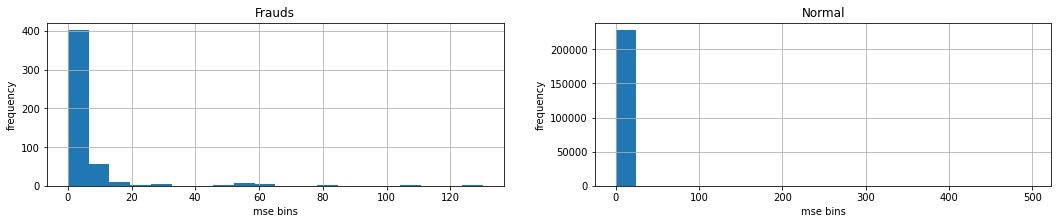

In [74]:
# Plot distribution of reconstruction errors
plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Frauds')
plt.hist(mse_frauds, bins=20)
plt.xlabel('mse bins')
plt.ylabel('frequency')
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Normal')
plt.hist(mse_train, bins=20)
plt.xlabel('mse bins')
plt.ylabel('frequency')
plt.grid()

plt.show()

In [0]:
def print_anomaly(AE,x_train,x_test,frauds):
  # Predict reconstruction error on training data
  x_train_hat = AE.predict(x_train)
  mse_train = np.mean(np.power(x_train - x_train_hat, 2), axis=1)

  x_test_hat = AE.predict(x_test)
  mse_test = np.mean(np.power(x_test - x_test_hat, 2), axis=1)
                     
  frauds_hat = AE.predict(frauds)
  mse_frauds = np.mean(np.power(frauds - frauds_hat, 2), axis=1)

  # Plot distribution of reconstruction errors
  plt.figure(figsize=(18, 3))

  plt.subplot(1, 2, 1)
  plt.title('Frauds')
  plt.hist(mse_frauds, bins=20)
  plt.xlabel('mse bins')
  plt.ylabel('frequency')
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.title('Normal')
  plt.hist(mse_train, bins=20)
  plt.xlabel('mse bins')
  plt.ylabel('frequency')
  plt.grid()

  plt.show()


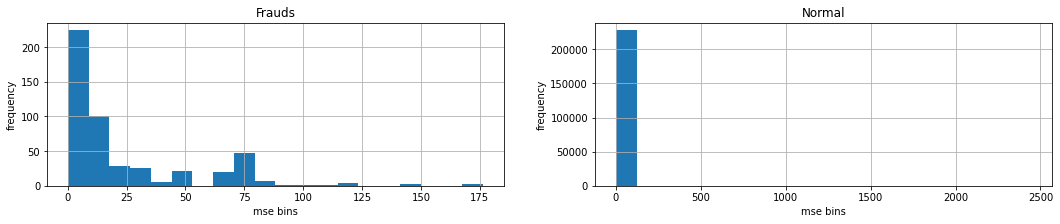

In [81]:
print_anomaly(AE,x_train,x_test,frauds)

# Part 3: Latent space

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
encoder_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_27 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_28 (Dense)             (None, 16)                400       
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

print(latent_normal.shape)
print(latent_frauds.shape)

(56863, 16)
(492, 16)


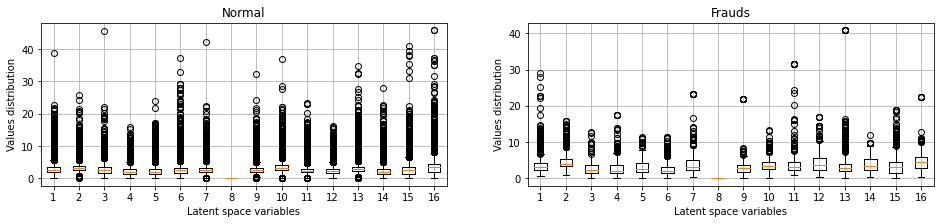

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(32, activation='relu')(in_layer)
encoder = Dense(24,  activation='relu')(encoder)

latent  = Dense(8,  activation='relu')(encoder)

decoder = Dense(24, activation='relu')(latent)
decoder = Dense(32, activation='relu')(decoder)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_45 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 200       
_________________________________________________________________
dense_47 (Dense)             (None, 24)                216       
_________________________________________________________________
dense_48 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_49 (Dense)             (None, 29)                957

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
encoder_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_45 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 200       
Total params: 1,952
Trainable params: 1,952
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

print(latent_normal.shape)
print(latent_frauds.shape)

(56863, 8)
(492, 8)


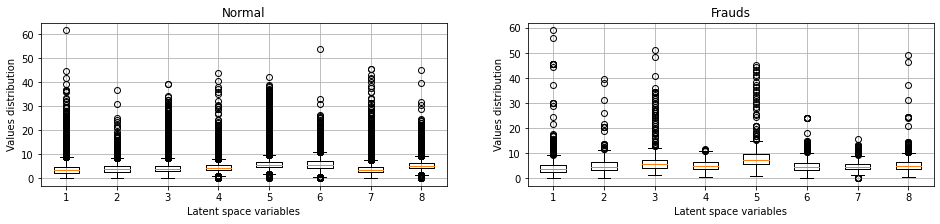

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

#Espacio latente ralo

Probamos con una capa previa de dropout

In [25]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(32, activation='relu')(in_layer)
encoder = Dense(24,  activation='relu')(encoder)
encoder = Dropout(0.7)(encoder)
latent  = Dense(32,  activation='relu')(encoder)

decoder = Dense(24, activation='relu')(latent)
decoder = Dense(32, activation='relu')(decoder)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_15 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_17 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_18 (Dense)             (None, 32)                800 

In [26]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
encoder_model.summary()

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

print(latent_normal.shape)
print(latent_frauds.shape)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_15 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                800       
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________
(56863, 32)
(492, 32)


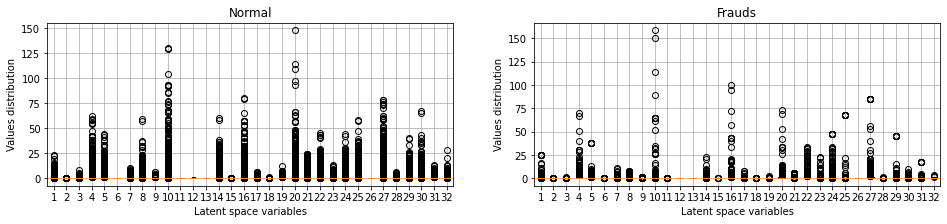

In [27]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

Prueba con un regularizador de acitivadad

In [0]:
from keras.regularizers import l1, l2, l1_l2

In [32]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(32, activation='relu')(in_layer)
encoder = Dense(24,  activation='relu')(encoder)
#encoder = Dropout(0.7)(encoder)
latent  = Dense(32,  activation='relu',activity_regularizer=l1(0.01))(encoder)

decoder = Dense(24, activation='relu')(latent)
decoder = Dense(32, activation='relu')(decoder)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=10, batch_size=64, validation_split=0.2)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_29 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_30 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_31 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_32 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_33 (Dense)             (None, 29)                957 

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
#encoder_model.summary()

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

#generate graphics
print_latent_space(latent_normal,latent_frauds)

In [0]:
def print_latent_space(latent_normal,latent_frauds):
# Plot distribution of latent space
  plt.figure(figsize=(16, 3))
  plt.subplot(1, 2, 1)
  plt.title('Normal')
  plt.boxplot(latent_normal)
  plt.xlabel('Latent space variables')  
  plt.ylabel('Values distribution')
  plt.grid()
  plt.subplot(1, 2, 2)
  plt.title('Frauds')
  plt.boxplot(latent_frauds)
  plt.xlabel('Latent space variables')
  plt.ylabel('Values distribution')
  plt.grid()
  plt.show()

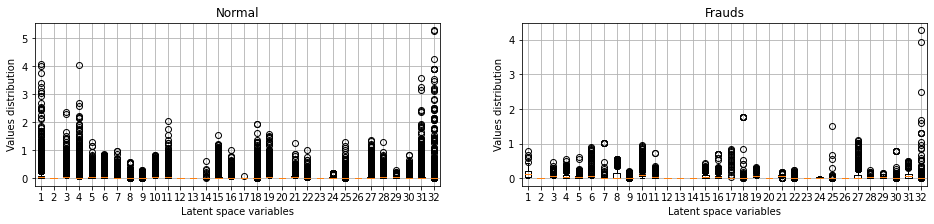

In [35]:
print_latent_space(latent_normal,latent_frauds)

In [79]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(32, activation='relu')(in_layer)
encoder = Dense(24,  activation='relu')(encoder)
latent  = Dense(32,  activation='relu',activity_regularizer=l1(0.1))(encoder)
decoder = Dense(24, activation='relu')(latent)
decoder = Dense(32, activation='relu')(decoder)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_114 (Dense)            (None, 32)                960       
_________________________________________________________________
dense_115 (Dense)            (None, 24)                792       
_________________________________________________________________
dense_116 (Dense)            (None, 32)                800       
_________________________________________________________________
dense_117 (Dense)            (None, 24)                792       
_________________________________________________________________
dense_118 (Dense)            (None, 32)                800       
_________________________________________________________________
dense_119 (Dense)            (None, 29)                957

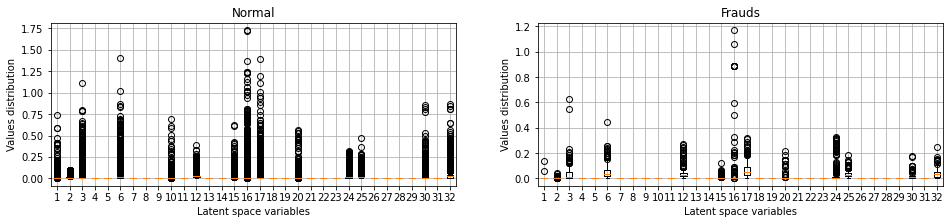

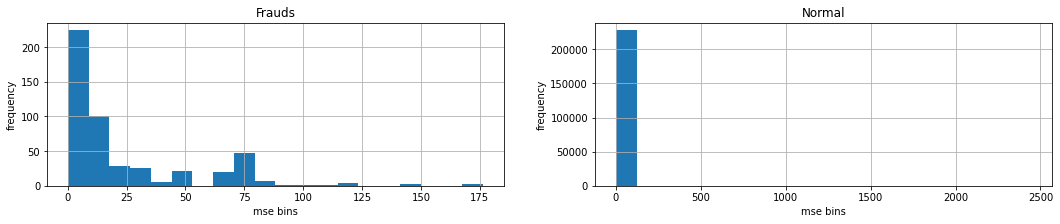

In [83]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
#encoder_model.summary()

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

#generate graphics
print_latent_space(latent_normal,latent_frauds)
print_anomaly(AE,x_train,x_test,frauds)

In [43]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(64, activation='relu')(in_layer)
encoder = Dense(32,  activation='tanh',activity_regularizer=l1(10e-5))(encoder)

latent  = Dense(24,  activation='relu',activity_regularizer=l1(.01))(encoder)

decoder = Dense(32, activation='relu')(latent)
decoder = Dense(64, activation='tanh',activity_regularizer=l1(10e-5))(decoder)

out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)                1920      
_________________________________________________________________
dense_59 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_60 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_61 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_62 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_63 (Dense)             (None, 29)                188

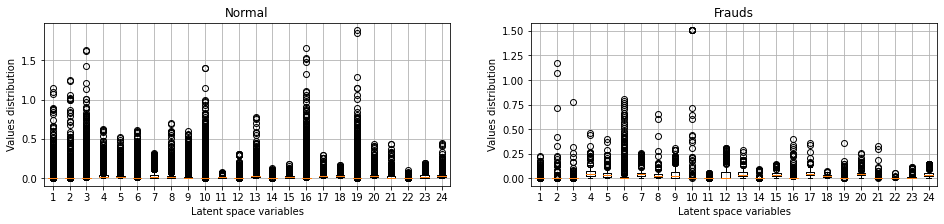

In [44]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
#encoder_model.summary()

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

#generate graphics
print_latent_space(latent_normal,latent_frauds)

In [45]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(64, activation='relu')(in_layer)
encoder = Dense(32,  activation='tanh',activity_regularizer=l1(10e-5))(encoder)
encoder = Dropout(0.5)(encoder)
latent  = Dense(64,  activation='relu',activity_regularizer=l1(.01))(encoder)

decoder = Dense(32, activation='relu')(latent)
decoder = Dense(64, activation='tanh',activity_regularizer=l1(10e-5))(decoder)

out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                1920      
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_67 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_68 (Dense)             (None, 64)                211

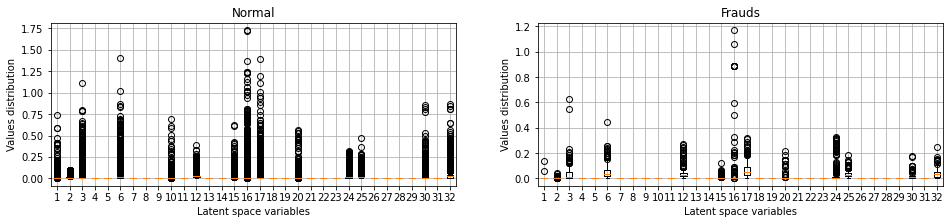

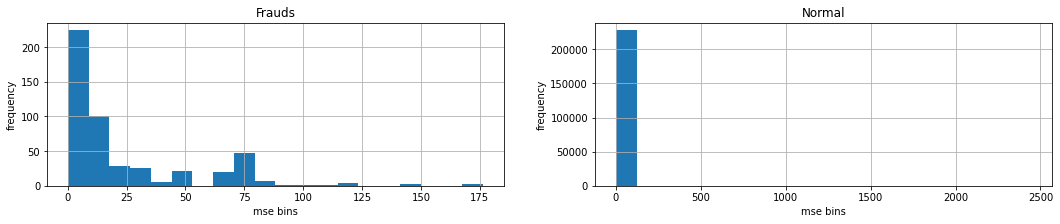

In [82]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
#encoder_model.summary()

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

#generate graphics
print_latent_space(latent_normal,latent_frauds)
print_anomaly(AE,x_train,x_test,frauds)

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_82 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_83 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_84 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_85 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_86 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_87 (Dense)             (None, 29)                374

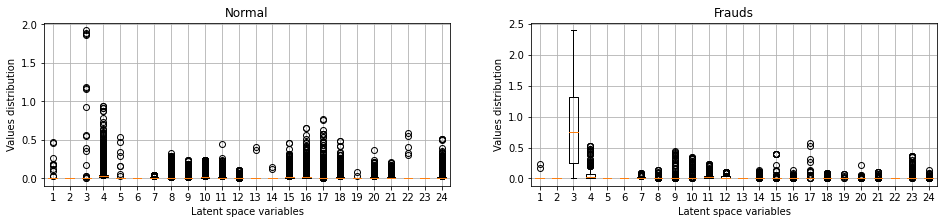

In [57]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(128, activation='relu')(in_layer)
encoder = Dense(32,  activation='tanh',activity_regularizer=l1(10e-5))(encoder)
#encoder = Dropout(0.5)(encoder)
latent  = Dense(24,  activation='relu',activity_regularizer=l1(.1))(encoder)

decoder = Dense(32, activation='relu')(latent)
decoder = Dense(128, activation='tanh',activity_regularizer=l1(10e-5))(decoder)

out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
#encoder_model.summary()

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

#generate graphics
print_latent_space(latent_normal,latent_frauds)

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_96 (Dense)             (None, 64)                1920      
_________________________________________________________________
dense_97 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_98 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_99 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_100 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_101 (Dense)            (None, 29)                188

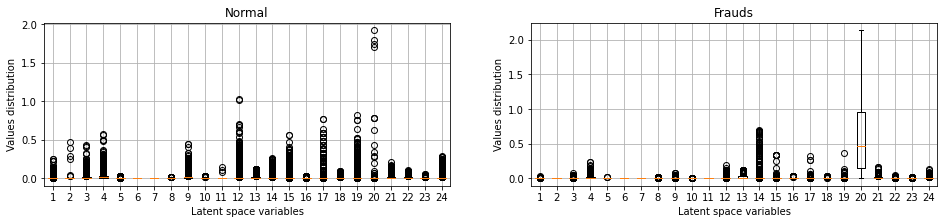

In [66]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(64, activation='relu')(in_layer)
encoder = Dense(32,  activation='tanh',activity_regularizer=l1(10e-5))(encoder)

latent  = Dense(24,  activation='relu',activity_regularizer=l1_l2(l1=.08,l2=.01))(encoder)

decoder = Dense(32, activation='relu')(latent)
decoder = Dense(64, activation='tanh',activity_regularizer=l1(10e-5))(decoder)

out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
#encoder_model.summary()

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

#generate graphics
print_latent_space(latent_normal,latent_frauds)

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_108 (Dense)            (None, 64)                1920      
_________________________________________________________________
dense_109 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_110 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_111 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_112 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_113 (Dense)            (None, 29)                188

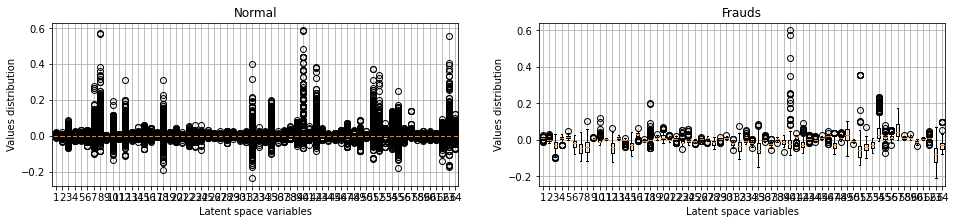

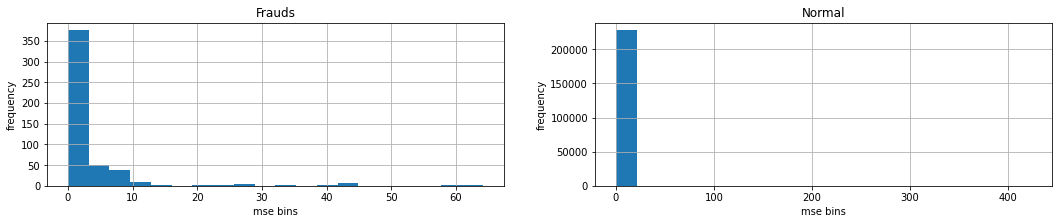

In [78]:
# Create model
in_layer = Input(shape=(x_train.shape[1],))

encoder = Dense(64, activation='elu')(in_layer)
encoder = Dense(32,  activation='tanh')(encoder)

latent  = Dense(64,  activation='elu',activity_regularizer=l1(.1))(encoder)

decoder = Dense(32, activation='tanh')(latent)
decoder = Dense(64, activation='elu')(decoder)

out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
#encoder_model.summary()

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

#generate graphics
print_latent_space(latent_normal,latent_frauds)
print_anomaly(AE,x_train,x_test,frauds)

In [0]:
  # == Q ==
# 1. Diseña un AE que obtenga pérdida menor o igual 0.01 tanto en entrenamiento como validación.
#    Reporta tu arquitectura.
# 2. ¿Existe alguna relación entre la profundidad del AE y la pérdida final?
# 3. ¿Existe alguna relación entre la profundidad del AE y la separación resultante
#    entre los espacios latentes de los datos normales y anormales?
# 4. ¿Existe alguna relación entre el número elementos en el espacio latente y la pérdida final?
# 5. ¿Existe alguna relación entre el número elementos en el espacio latente y la separación resultante
#    entre los espacios latentes de los datos normales y anormales?
# 6. Intenta forzar el espacio latente para que sea ralo. Reporta tu mejor modelo y 
#    el desempeño que obtenga, tanto en pérdida como en capacidad de diferenciar datos anormales.